In [1]:
import os, os.path
import numpy as np
import pandas as pd
import model_attributes as ma
from attribute_table import AttributeTable
import datetime
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_energy as me
import model_electricity as ml
import model_socioeconomic as se
from model_socioeconomic import Socioeconomic
import setup_analysis as sa
import support_functions as sf
import importlib
import re
import time
import warnings
import matplotlib.pyplot as plt
from typing import *

importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
importlib.reload(ml)

warnings.filterwarnings("ignore")

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2192: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2192: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


In [4]:
dir_energy_potentials = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/Energy"
dir_irena = os.path.join(dir_energy_potentials, "irena_generation_potential_data")

# get some attributes
attr_hour = sa.model_attributes.dict_attributes.get("hour")
attr_region = sa.model_attributes.dict_attributes.get(f"{sa.model_attributes.dim_region}")
attr_sector = sa.model_attributes.dict_attributes.get("abbreviation_sector")
attr_strat = sa.model_attributes.dict_attributes.get(f"dim_{sa.model_attributes.dim_strategy_id}")
attr_time_period = sa.model_attributes.dict_attributes.get(f"dim_{sa.model_attributes.dim_time_period}")
attr_time_slice = sa.model_attributes.dict_attributes.get(f"time_slice")
attr_tg1 = sa.model_attributes.dict_attributes.get("ts_group_1")
attr_tg2 = sa.model_attributes.dict_attributes.get("ts_group_2")

# attribute derivatives
dict_country_to_iso = dict((k, v.upper()) for k, v in attr_region.field_maps.get(f"{attr_region.key}_to_{attr_region.key}_abbreviation").items())
dict_iso_to_country = sf.reverse_dict(dict_country_to_iso)
dict_country_to_cf_region = attr_region.field_maps.get(f"{attr_region.key}_to_hourly_capacity_factor_region")
dict_iso_to_cf_region = dict((dict_country_to_iso.get(k), v) for k, v in dict_country_to_cf_region.items())

# set some fields
field_country = "country"
field_iso = "iso_code3"
field_hour = attr_hour.key
field_hour_group = "hour_group"
field_time_period = attr_time_period.key
field_year = "year"

# call variables from the electric model
model_elec = ml.ElectricEnergy(sa.model_attributes, sa.dir_jl, sa.dir_ref_nemo, initialize_julia = False)


##  SET SOME DiCTIONARIES

# used in a number of places
dict_n_days_per_month = {
    1: 31,
    2: 28,
    3: 31,
    4: 30,
    5: 31,
    6: 30,
    7: 31,
    8: 31,
    9: 30,
    10: 31,
    11: 30,
    12: 31
}
# weights days/month on average when only monthly data are avaiable
dict_num_days_per_month_weights = dict((k, (v if (k != 2) else 28.25)) for k, v in dict_n_days_per_month.items())
# format month/time group 1 dictionaries
dict_tg1_to_months = dict(
    (k, [int(x) for x in v.split("|")]) for k, v in attr_tg1.field_maps.get(f"{attr_tg1.key}_to_months").items())
# map each month to the TG1
dict_month_to_tg1 = {}
for k in dict_tg1_to_months.keys():
    mos = dict_tg1_to_months.get(k)
    for m in mos:
        dict_month_to_tg1.update({m: k})

# hour group dictionaries -- et up the regular expression to match hour groups on
dict_hour_to_hour_group = attr_hour.field_maps.get(f"{attr_hour.key}_to_hour_group")
def regex_by_hour_group(
    hour_group: int
) -> Union[str, None]:
    return re.compile(f"(\D*)_w(\D*){hour_group}$")
# iterate to build dictionary
all_hour_groups = list(set(dict_hour_to_hour_group.values()))
dict_time_slice_to_hour_group = {}
for hg in all_hour_groups:
    regex = regex_by_hour_group(hg)
    for time_slice in attr_time_slice.key_values:
        if regex.match(time_slice) is not None:
            dict_time_slice_to_hour_group.update({time_slice: hg})

# Renewable generation potentials are important for constraining capacities
- Use this notebook to esimate renewable generation potentials

# General Data Sources
- International Renewable ENergy Agency (IRENA)
    - IRENA Global Atlas: https://globalatlas.irena.org/

# Hydropower Generation Potential

IRENA_tudelft_global_hydropower.csv
-----------------------------------

#### RAW DATA
https://data.4tu.nl/articles/dataset/Global_potential_hydropower_locations/12708413/1

#### CITE
Hoes O.A.C. (2014): Global potential hydropower locations. 4TU.ResearchData. Dataset. https://doi.org/10.4121/uuid:99b42e30-5a69-4a53-8e77-c954f11dbc76 Copy citation


#### IRENA LAYER (box around LAC)
"Global hydropower potential" (TU-Delft)

#### ACCESS DATE: 
2/20/2023

In [25]:



###
###    TEMPORARY UNTIL SCRIPT CAN BE PORTED: READ FROM SUMMARY GENERATED BY N. KALRA
###

df_hydro = pd.read_csv(os.path.join(dir_irena, "IRENA_tudelft_global_hydropower_country_summary_of_capacity.csv"))
cat_hydro = "pp_hydropower"
# TEMP - ASSIGN CAPACITY AS SOME FRACTION OVER PEAK RESIDUAL
#dir_calibs = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/calibrated_input_files_from_edmundo"
#fp_hydro = os.path.join(dir_calibs, "all", "datos_calibrados_20230220_PARTIAL.csv")
#df_hydro = pd.read_csv(fp_hydro)

# use nominal residual capacity
df_residual_capacity = pd.read_csv(sa.fp_csv_nemomod_residual_capacity_inputs)
df_residual_capacity[attr_time_period.key] = df_residual_capacity[field_year].replace(attr_time_period.field_maps.get(f"year_to_{attr_time_period.key}"))
df_residual_capacity = df_residual_capacity[
    df_residual_capacity[attr_time_period.key].isin(attr_time_period.key_values)
]
df_residual_capacity[field_country].replace(dict_country_to_iso, inplace = True)
df_residual_capacity.rename(columns = {field_country: field_iso}, inplace = True)

field_hydro_re_capacity = sa.model_attributes.build_varlist(
    sa.model_attributes.subsec_name_entc,
    "NemoMod ResidualCapacity",
    restrict_to_category_values = [cat_hydro]
)[0]
df_hydro_residual = df_residual_capacity[[field_time_period, field_iso, field_hydro_re_capacity]]


# search for highest
dict_iso_to_capacity = {}
max_capacity_scalar = 1.5
df_hydro_residual_grouped = df_hydro_residual.groupby([field_iso])
for df in df_hydro_residual_grouped:
    i, df = df
    
    new_max = max_capacity_scalar*max(df[field_hydro_re_capacity])
    
    dict_iso_to_capacity.update({i: new_max})

    
# build output capacity cap
df_hydro_cap_synthetic = df_hydro_residual.copy()
df_hydro_cap_synthetic.drop(field_hydro_re_capacity, axis = 1, inplace = True)

modvar_tech_max = "NemoMod TotalAnnualMaxCapacity"
field_tech_max = sa.model_attributes.build_varlist(
    sa.model_attributes.subsec_name_entc,
    modvar_tech_max,
    restrict_to_category_values = ["pp_hydropower"]
)[0]
df_hydro_cap_synthetic[field_tech_max] = df_hydro_cap_synthetic[field_iso].replace(dict_iso_to_capacity)
df_hydro_cap_synthetic.to_csv(
    sa.fp_csv_nemomod_hydropower_max_tech_capacity,
    index = None,
    encoding = "UTF-8"
)



In [19]:
#df_hydro_cap_synthetic[df_hydro_cap_synthetic[field_iso].isin(["BRA"])]

# Geothermal Generation Potential

IRENA_hdr_Pt_14_global.tiff (BEARDSMORE)
----------------------------------------

#### RAW DATA


#### CITE
Beardsmore et al. (2011). A Protocol for Estimating and Mapping Global EGS Potential. DOI: 10.13140/RG.2.2.33475.71204

#### IRENA LAYER (box around LAC)
Layer "Global total EGS technical potential 14% recovery" (HDR)

#### ACCESS DATE: 
2/20/2023



IRENA_hdr_TotalTheoretical_global.tiff (BEARDSMORE)
---------------------------------------------------

#### RAW DATA


#### CITE
Beardsmore et al. (2011). A Protocol for Estimating and Mapping Global EGS Potential. DOI: 10.13140/RG.2.2.33475.71204

#### IRENA LAYER (box around LAC)
Layer "Global EGS theoretical potential 2.5–3.5 km depth" (HDR)

#### ACCESS DATE: 
2/20/2023


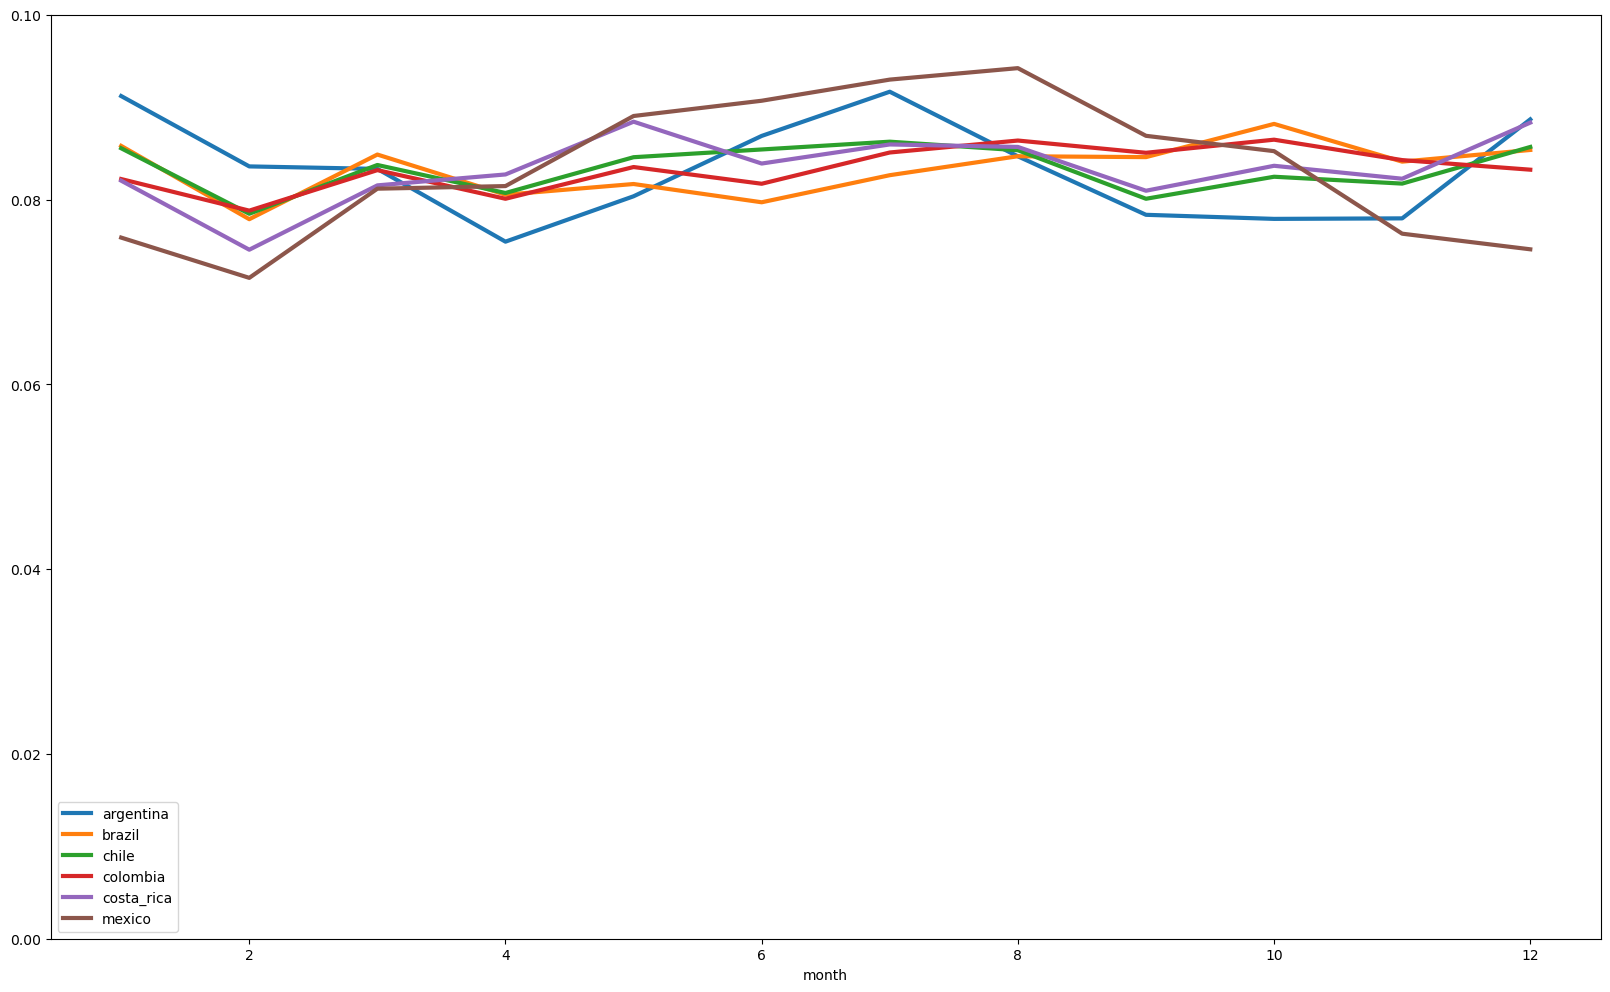

In [258]:

fig, ax = plt.subplots(figsize = (20, 12))
ax.set_ylim(0, 0.1)
dfs_plot = df_production_monthly_average_by_cfr.groupby(["cfr"])
for i, df in dfs_plot:
    df[[field_month, field_distribution_load_monthly]].rename(columns = {field_distribution_load_monthly: i}).plot(
        x = field_month, ax = ax, linewidth = 3
    )
    
    
    
fig, ax = plt.subplots(figsize = (20, 12))
ax.set_ylim(0, 0.1)
dfs_plot = df_production_monthly_average.groupby(["Country"])
for i, df in dfs_plot:
    df[[field_month, field_distribution_load_monthly]].rename(columns = {field_distribution_load_monthly: i}).plot(
        x = field_month, ax = ax, linewidth = 3
    )
    